In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [3]:
df = pd.read_csv("/kaggle/input/student-performance-factors/StudentPerformanceFactors.csv")

print(f"Dataset Shape: {df.shape}")
print(f"Number of students: {len(df)}")
print(f"Number of features: {len(df.columns) - 1}")

print("\nDataset Info:")
print(df.info())

print("\nFirst 5 rows:")
print(df.head())

print("\nBasic Statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (6607, 20)
Number of students: 6607
Number of features: 19

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type    

In [4]:
print(df.isnull().sum())

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


In [5]:
print(df['Teacher_Quality'].value_counts())
print(df['Parental_Education_Level'].value_counts())
print(df['Distance_from_Home'].value_counts())

Teacher_Quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64
Parental_Education_Level
High School     3223
College         1989
Postgraduate    1305
Name: count, dtype: int64
Distance_from_Home
Near        3884
Moderate    1998
Far          658
Name: count, dtype: int64


In [6]:
categorical_cols = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col} value counts:")
        print(df[col].value_counts())

df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)
df['Parental_Education_Level'].fillna(df['Parental_Education_Level'].mode()[0], inplace=True)
df['Distance_from_Home'].fillna(df['Distance_from_Home'].mode()[0], inplace=True)

print(f"\nMissing values after filling:")
print(df.isnull().sum())


Teacher_Quality value counts:
Teacher_Quality
Medium    3925
High      1947
Low        657
Name: count, dtype: int64

Parental_Education_Level value counts:
Parental_Education_Level
High School     3223
College         1989
Postgraduate    1305
Name: count, dtype: int64

Distance_from_Home value counts:
Distance_from_Home
Near        3884
Moderate    1998
Far          658
Name: count, dtype: int64

Missing values after filling:
Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home     

In [7]:
ordinal_maps = {
    'Parental_Involvement': {'Low': 0, 'Medium': 1, 'High': 2},
    'Access_to_Resources': {'Low': 0, 'Medium': 1, 'High': 2},
    'Motivation_Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Family_Income': {'Low': 0, 'Medium': 1, 'High': 2},
    'Teacher_Quality': {'Low': 0, 'Medium': 1, 'High': 2},
    'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2},
    'Distance_from_Home': {'Near': 0, 'Moderate': 1, 'Far': 2},
    'Peer_Influence': {'Negative': -1, 'Neutral': 0, 'Positive': 1}
}

for col, mapping in ordinal_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)
        print(f"Encoded {col}: {mapping}")

binary_maps = {
    'Internet_Access': {'Yes': 1, 'No': 0},
    'Extracurricular_Activities': {'Yes': 1, 'No': 0},
    'Learning_Disabilities': {'Yes': 1, 'No': 0},
    'Gender': {'Male': 1, 'Female': 0},
    'School_Type': {'Private': 1, 'Public': 0}
}

for col, mapping in binary_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)
        print(f"Encoded {col}: {mapping}")

Encoded Parental_Involvement: {'Low': 0, 'Medium': 1, 'High': 2}
Encoded Access_to_Resources: {'Low': 0, 'Medium': 1, 'High': 2}
Encoded Motivation_Level: {'Low': 0, 'Medium': 1, 'High': 2}
Encoded Family_Income: {'Low': 0, 'Medium': 1, 'High': 2}
Encoded Teacher_Quality: {'Low': 0, 'Medium': 1, 'High': 2}
Encoded Parental_Education_Level: {'High School': 0, 'College': 1, 'Postgraduate': 2}
Encoded Distance_from_Home: {'Near': 0, 'Moderate': 1, 'Far': 2}
Encoded Peer_Influence: {'Negative': -1, 'Neutral': 0, 'Positive': 1}
Encoded Internet_Access: {'Yes': 1, 'No': 0}
Encoded Extracurricular_Activities: {'Yes': 1, 'No': 0}
Encoded Learning_Disabilities: {'Yes': 1, 'No': 0}
Encoded Gender: {'Male': 1, 'Female': 0}
Encoded School_Type: {'Private': 1, 'Public': 0}


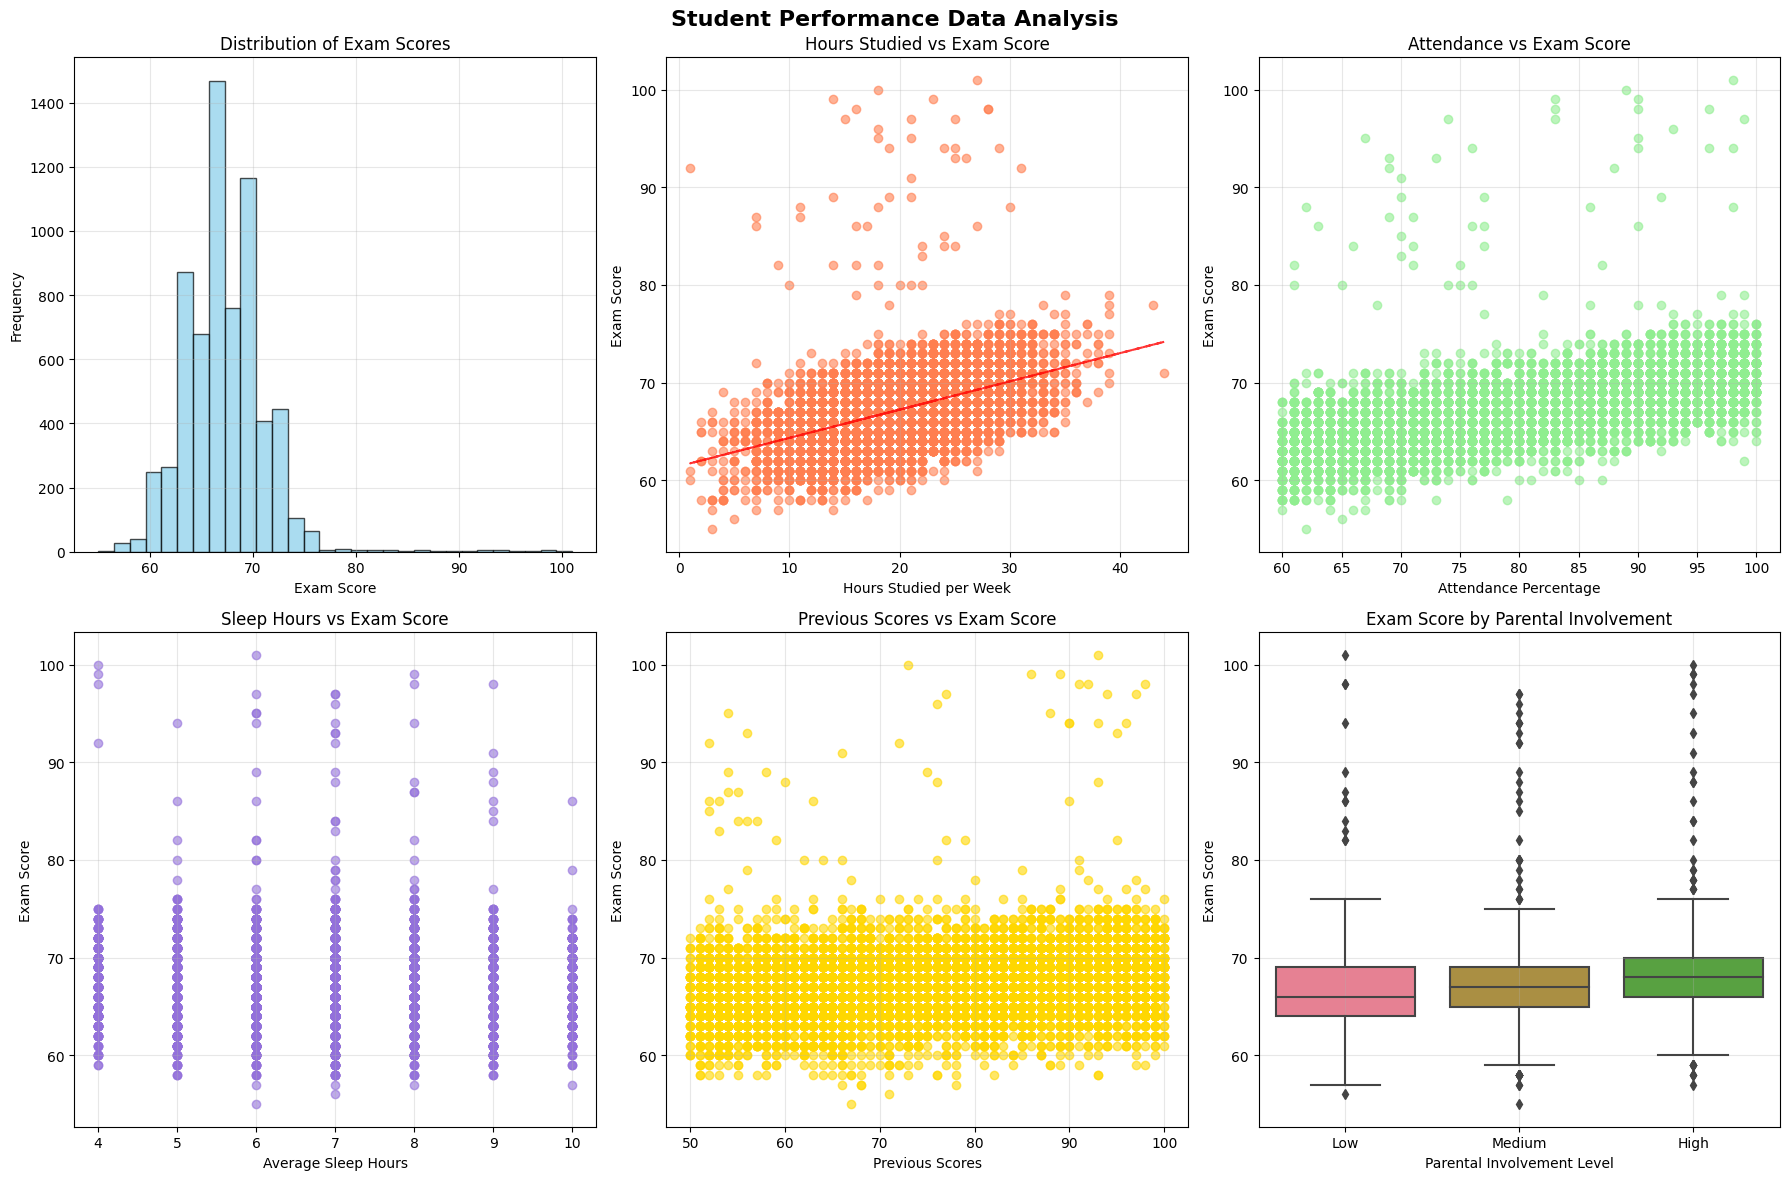

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Student Performance Data Analysis', fontsize=16, fontweight='bold')

# Distribution of Exam Scores
axes[0, 0].hist(df['Exam_Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Exam Scores')
axes[0, 0].set_xlabel('Exam Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Hours Studied vs Exam Score
axes[0, 1].scatter(df['Hours_Studied'], df['Exam_Score'], alpha=0.6, color='coral')
axes[0, 1].set_title('Hours Studied vs Exam Score')
axes[0, 1].set_xlabel('Hours Studied per Week')
axes[0, 1].set_ylabel('Exam Score')
axes[0, 1].grid(True, alpha=0.3)

# trend line
z = np.polyfit(df['Hours_Studied'], df['Exam_Score'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['Hours_Studied'], p(df['Hours_Studied']), "r--", alpha=0.8)

# Attendance vs Exam Score
axes[0, 2].scatter(df['Attendance'], df['Exam_Score'], alpha=0.6, color='lightgreen')
axes[0, 2].set_title('Attendance vs Exam Score')
axes[0, 2].set_xlabel('Attendance Percentage')
axes[0, 2].set_ylabel('Exam Score')
axes[0, 2].grid(True, alpha=0.3)

# Sleep Hours vs Exam Score
axes[1, 0].scatter(df['Sleep_Hours'], df['Exam_Score'], alpha=0.6, color='mediumpurple')
axes[1, 0].set_title('Sleep Hours vs Exam Score')
axes[1, 0].set_xlabel('Average Sleep Hours')
axes[1, 0].set_ylabel('Exam Score')
axes[1, 0].grid(True, alpha=0.3)

# Previous Scores vs Exam Score
axes[1, 1].scatter(df['Previous_Scores'], df['Exam_Score'], alpha=0.6, color='gold')
axes[1, 1].set_title('Previous Scores vs Exam Score')
axes[1, 1].set_xlabel('Previous Scores')
axes[1, 1].set_ylabel('Exam Score')
axes[1, 1].grid(True, alpha=0.3)

# Box plot for categorical variable
df_temp = df.copy()

involvement_map = {0: 'Low', 1: 'Medium', 2: 'High'}
df_temp['Parental_Involvement_Cat'] = df['Parental_Involvement'].map(involvement_map)
sns.boxplot(data=df_temp, x='Parental_Involvement_Cat', y='Exam_Score', ax=axes[1, 2])
axes[1, 2].set_title('Exam Score by Parental Involvement')
axes[1, 2].set_xlabel('Parental Involvement Level')
axes[1, 2].set_ylabel('Exam Score')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

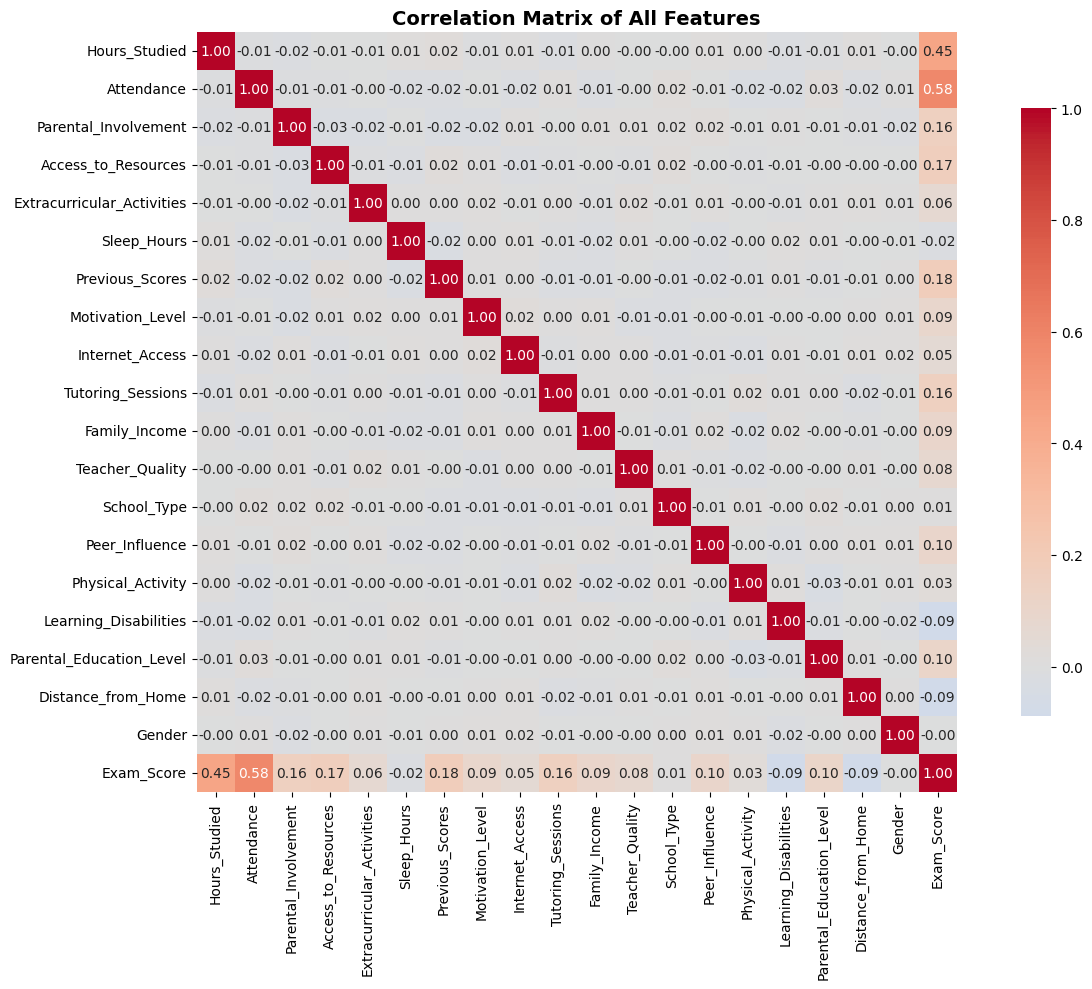

Features correlation with Exam Score:
Attendance                    0.581072
Hours_Studied                 0.445455
Previous_Scores               0.175079
Access_to_Resources           0.169770
Parental_Involvement          0.157114
Tutoring_Sessions             0.156525
Parental_Education_Level      0.103817
Peer_Influence                0.100217
Family_Income                 0.094555
Distance_from_Home           -0.088934
Motivation_Level              0.086937
Learning_Disabilities        -0.085066
Teacher_Quality               0.076684
Extracurricular_Activities    0.064382
Internet_Access               0.051475
Physical_Activity             0.027824
Sleep_Hours                  -0.017022
School_Type                   0.008844
Gender                       -0.002032
Name: Exam_Score, dtype: float64


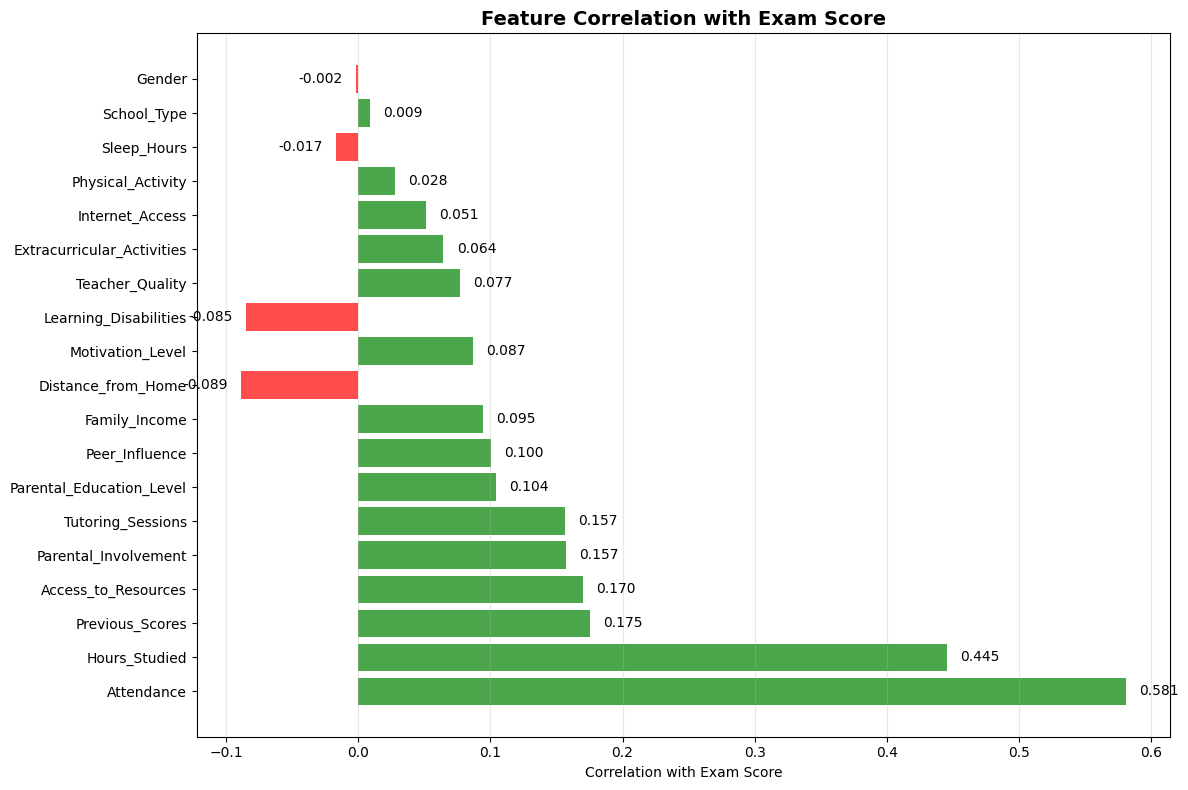

In [9]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature correlation with target
target_corr = correlation_matrix['Exam_Score'].drop('Exam_Score').sort_values(key=abs, ascending=False)
print("Features correlation with Exam Score:")
print(target_corr)

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
bars = plt.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_corr)), target_corr.index)
plt.xlabel('Correlation with Exam Score')
plt.title('Feature Correlation with Exam Score', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

for i, (bar, value) in enumerate(zip(bars, target_corr.values)):
    plt.text(value + (0.01 if value > 0 else -0.01), i, f'{value:.3f}', 
            va='center', ha='left' if value > 0 else 'right')

plt.tight_layout()
plt.show()

In [10]:
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training percentage: {len(X_train)/len(X)*100:.1f}%")
print(f"Testing percentage: {len(X_test)/len(X)*100:.1f}%")

Training set size: (5285, 19)
Test set size: (1322, 19)
Training percentage: 80.0%
Testing percentage: 20.0%


In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Polynomial Regression (degree=2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_test_pred
    }
    
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Training RMSE: {np.sqrt(train_mse):.4f}")
    print(f"Testing RMSE: {np.sqrt(test_mse):.4f}")
    print(f"CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Training Linear Regression...
Training R²: 0.7169
Testing R²: 0.7709
Training RMSE: 2.0866
Testing RMSE: 1.7994
CV R² Score: 0.7237 (+/- 0.1749)

Training Ridge Regression...
Training R²: 0.7169
Testing R²: 0.7709
Training RMSE: 2.0866
Testing RMSE: 1.7994
CV R² Score: 0.7237 (+/- 0.1749)

Training Lasso Regression...
Training R²: 0.5579
Testing R²: 0.6179
Training RMSE: 2.6076
Testing RMSE: 2.3239
CV R² Score: 0.5646 (+/- 0.1510)

Training Polynomial Regression (degree=2)...
Training R²: 0.7284
Testing R²: 0.7598
Training RMSE: 2.0439
Testing RMSE: 1.8427
CV R² Score: 0.7052 (+/- 0.1723)

Training Random Forest...
Training R²: 0.9485
Testing R²: 0.6661
Training RMSE: 0.8897
Testing RMSE: 2.1726
CV R² Score: 0.6242 (+/- 0.1562)


                              Model  Test R²  Test RMSE  Test MAE  CV R² Mean  \
0                 Linear Regression   0.7709     1.7994    0.4443      0.7237   
1                  Ridge Regression   0.7709     1.7994    0.4443      0.7237   
2                  Lasso Regression   0.6179     2.3239    1.3746      0.5646   
3  Polynomial Regression (degree=2)   0.7598     1.8427    0.5599      0.7052   
4                     Random Forest   0.6661     2.1726    1.0808      0.6242   

   CV R² Std  
0     0.0874  
1     0.0874  
2     0.0755  
3     0.0861  
4     0.0781  

Best performing model: Ridge Regression
Best Test R² Score: 0.7709


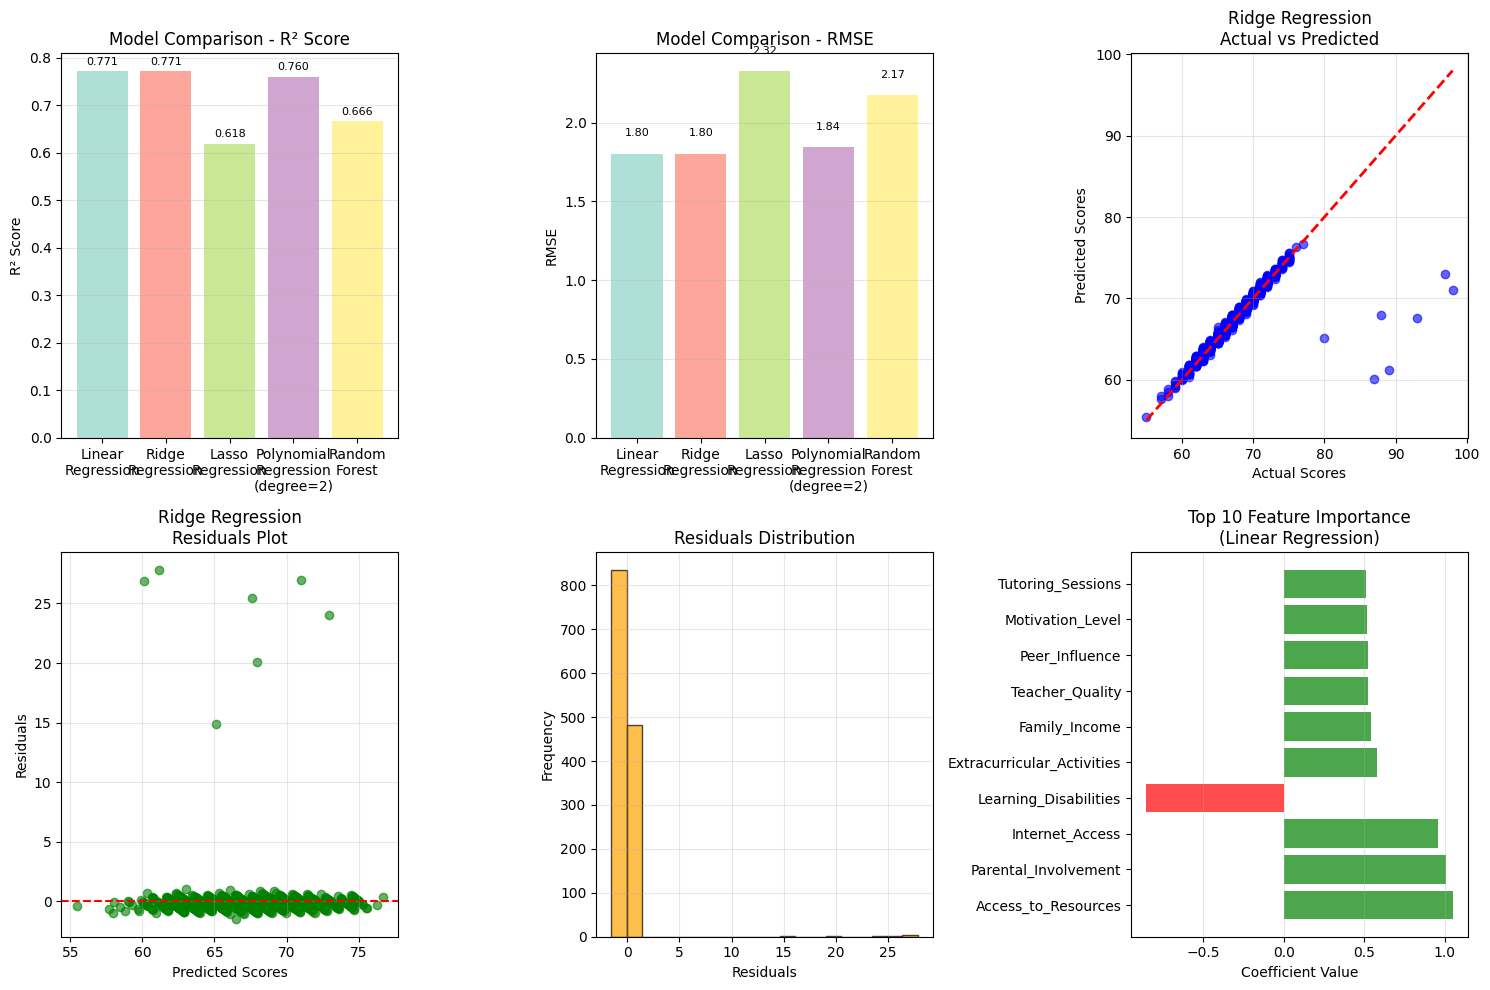

In [12]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test R²': [results[model]['test_r2'] for model in results.keys()],
    'Test RMSE': [np.sqrt(results[model]['test_mse']) for model in results.keys()],
    'Test MAE': [results[model]['test_mae'] for model in results.keys()],
    'CV R² Mean': [results[model]['cv_mean'] for model in results.keys()],
    'CV R² Std': [results[model]['cv_std'] for model in results.keys()]
})

print(results_df.round(4))

# best model
best_model_name = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
print(f"\nBest performing model: {best_model_name}")
print(f"Best Test R² Score: {results_df['Test R²'].max():.4f}")

plt.figure(figsize=(15, 10))

# R² Score comparison
plt.subplot(2, 3, 1)
model_names = list(results.keys())
r2_scores = [results[name]['test_r2'] for name in model_names]
colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
bars = plt.bar(range(len(model_names)), r2_scores, color=colors, alpha=0.7)
plt.title('Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xticks(range(len(model_names)), [name.replace(' ', '\n') for name in model_names], rotation=0)
plt.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2., score + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# RMSE comparison
plt.subplot(2, 3, 2)
rmse_scores = [np.sqrt(results[name]['test_mse']) for name in model_names]
bars = plt.bar(range(len(model_names)), rmse_scores, color=colors, alpha=0.7)
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.xticks(range(len(model_names)), [name.replace(' ', '\n') for name in model_names], rotation=0)
plt.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2., score + 0.1,
            f'{score:.2f}', ha='center', va='bottom', fontsize=8)

# Best model predictions visualization
best_predictions = results[best_model_name]['predictions']

# Actual vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(y_test, best_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'{best_model_name}\nActual vs Predicted')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(2, 3, 4)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'{best_model_name}\nResiduals Plot')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Residuals histogram
plt.subplot(2, 3, 5)
plt.hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Feature importance (for linear regression)
plt.subplot(2, 3, 6)
if 'Linear Regression' in models:
    linear_model = models['Linear Regression']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': linear_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    colors = ['green' if x > 0 else 'red' for x in feature_importance['coefficient']]
    bars = plt.barh(range(min(10, len(feature_importance))), 
                   feature_importance['coefficient'].head(10), color=colors, alpha=0.7)
    plt.yticks(range(min(10, len(feature_importance))), 
              feature_importance['feature'].head(10))
    plt.xlabel('Coefficient Value')
    plt.title('Top 10 Feature Importance\n(Linear Regression)')
    plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Linear Regression Feature Importance (by coefficient magnitude):
                       Feature  Coefficient  Abs_Coefficient
3          Access_to_Resources     1.048347         1.048347
2         Parental_Involvement     1.005249         1.005249
8              Internet_Access     0.955759         0.955759
15       Learning_Disabilities    -0.853972         0.853972
4   Extracurricular_Activities     0.577675         0.577675
10               Family_Income     0.539257         0.539257
11             Teacher_Quality     0.524762         0.524762
13              Peer_Influence     0.521452         0.521452
7             Motivation_Level     0.519537         0.519537
9            Tutoring_Sessions     0.508460         0.508460
16    Parental_Education_Level     0.481747         0.481747
17          Distance_from_Home    -0.463327         0.463327
0                Hours_Studied     0.292978         0.292978
1                   Attendance     0.198991         0.198991
14           Physica

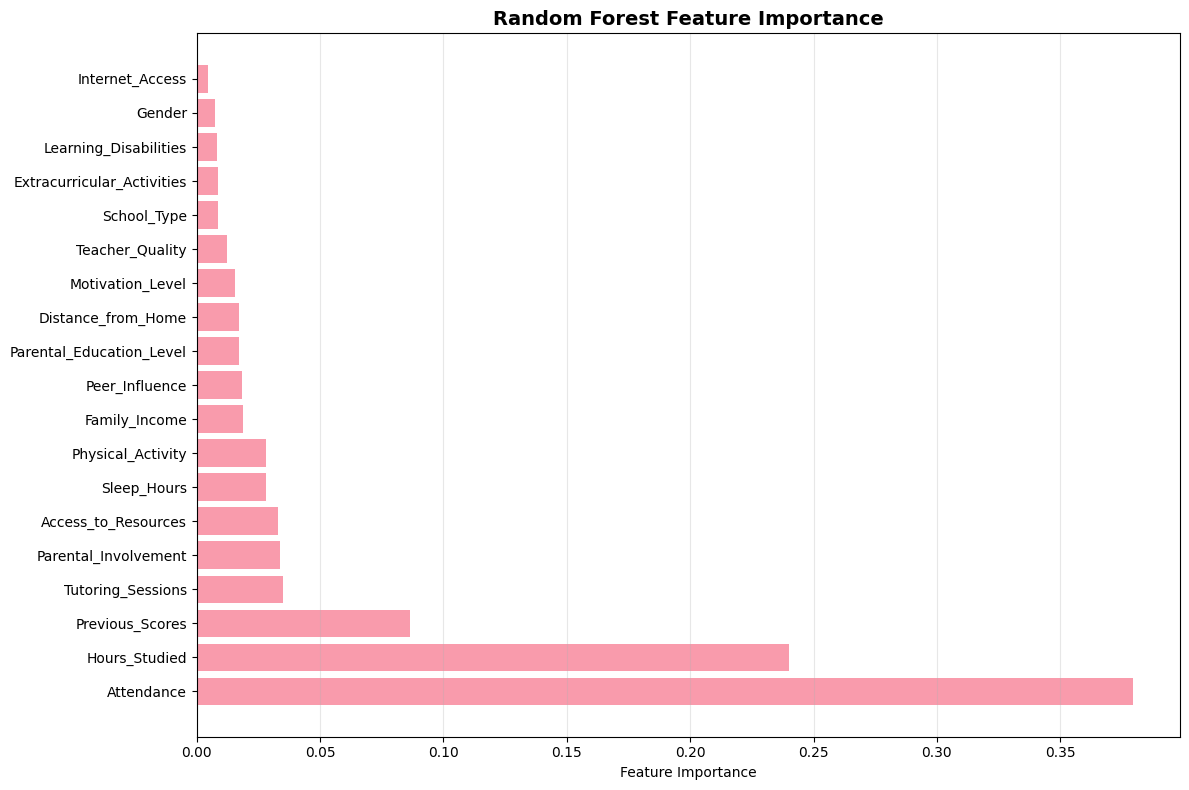

In [13]:
# Linear regression coefficients
if 'Linear Regression' in models:
    linear_model = models['Linear Regression']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': linear_model.coef_,
        'Abs_Coefficient': np.abs(linear_model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("Linear Regression Feature Importance (by coefficient magnitude):")
    print(feature_importance)

# Random Forest feature importance
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    rf_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nRandom Forest Feature Importance:")
    print(rf_importance)
    
    # Plot Random Forest feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(rf_importance)), rf_importance['Importance'], alpha=0.7)
    plt.yticks(range(len(rf_importance)), rf_importance['Feature'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

In [14]:
print(f"1. Best performing model: {best_model_name}")
print(f"   - Test R² Score: {results[best_model_name]['test_r2']:.4f}")
print(f"   - Test RMSE: {np.sqrt(results[best_model_name]['test_mse']):.4f}")

print(f"\n2. Top 5 most important features (Linear Regression):")
if 'Linear Regression' in models:
    for i, (_, row) in enumerate(feature_importance.head().iterrows()):
        print(f"   {i+1}. {row['Feature']}: {row['Coefficient']:.4f}")

print(f"\n3. Model Performance Summary:")
print(f"   - Linear Regression explains {results['Linear Regression']['test_r2']:.1%} of variance")
print(f"   - Polynomial Regression explains {results['Polynomial Regression (degree=2)']['test_r2']:.1%} of variance")
if 'Random Forest' in results:
    print(f"   - Random Forest explains {results['Random Forest']['test_r2']:.1%} of variance")

print(f"\n4. Key Findings:")
print(f"   - Hours studied has correlation of {target_corr['Hours_Studied']:.3f} with exam scores")
print(f"   - Previous scores have correlation of {target_corr['Previous_Scores']:.3f} with exam scores")
print(f"   - Attendance has correlation of {target_corr['Attendance']:.3f} with exam scores")

1. Best performing model: Ridge Regression
   - Test R² Score: 0.7709
   - Test RMSE: 1.7994

2. Top 5 most important features (Linear Regression):
   1. Access_to_Resources: 1.0483
   2. Parental_Involvement: 1.0052
   3. Internet_Access: 0.9558
   4. Learning_Disabilities: -0.8540
   5. Extracurricular_Activities: 0.5777

3. Model Performance Summary:
   - Linear Regression explains 77.1% of variance
   - Polynomial Regression explains 76.0% of variance
   - Random Forest explains 66.6% of variance

4. Key Findings:
   - Hours studied has correlation of 0.445 with exam scores
   - Previous scores have correlation of 0.175 with exam scores
   - Attendance has correlation of 0.581 with exam scores
